# Multiple linear regression (with numpy)

In the simple linear regression model, we fit the dependence relation between a single independent variable and an dependent variable. We can generalize by adding more coefficients to our model. With $n$ independent variables:

$$\hat{y} = \hat{\beta_0} + \hat{\beta_1}x_1 + ... + \hat{\beta_n}x_n  = \hat{\beta_0} + \sum_{i=1}^n{\hat{\beta_i}x_i}$$

Let's implement that using numpy instead of native python. The main advantage is that numpy allows for fast compiled vectorized operations.

With $\mathbf{y}$ as the vector of observations of the response variable, $\mathbf{X}$ the matrix of n regressors per m sample (we add a vector of 1 to the first column for $\beta_0$ so the matrix is actually n+1 by m) and $\mathbf{\beta}$ is the vector containing the model coefficients. We can express the model:

$$\mathbf{y} = \mathbf{X} \cdot \mathbf{\beta} = \mathbf{X} \mathbf{\beta}^\intercal$$

The Mean Error can be expressed as:

$$ME(\mathbf{\beta}) = \dfrac{1}{n} ((\mathbf{X} \cdot \mathbf{\beta}) - \mathbf{y})$$

The update rule used to regress the coefficients using Mean Error is:

$$\mathbf{\beta} := \mathbf{\beta} - \alpha \dfrac{1}{n} (\mathbf{y}^\intercal \cdot ((\mathbf{X} \cdot \mathbf{\beta}) - \mathbf{y}))$$

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import csv


def standardize(a):
    mu = np.mean(a, axis=0)
    sigma = np.std(a, axis=0)
    std_a = (a - mu) / sigma
    return std_a, mu, sigma


class LinearModel():
    def __init__(self):
        self._parameters = None

    # fit the model to the data using gradient descent of the mean error
    def fit(self, regressors, regressands, learning_rate=0.0001, iterations=1000):
        mean_error_history = np.zeros(iterations)
        std_parameters = np.zeros(regressors.shape[1] + 1, dtype=np.float64)
        std_regressors, mu_regressors, sigma_regressors = standardize(regressors)
        std_regressands, mu_regressands, sigma_regressands = standardize(regressands)
        # add a column of 1 to X so the first coefficients is the intercept
        std_regressors = np.insert(std_regressors, 0, np.ones(len(std_regressors)), axis=1)
        for epoch in range(iterations):
            predictions = np.dot(std_regressors, std_parameters)
            errors = predictions - std_regressands
            std_parameters = std_parameters - learning_rate * np.dot(std_regressors.T, errors) / len(regressors)
            mean_error_history[epoch] = np.mean(errors)
        # unstandardize the parameters
        unstandardize_transform = np.zeros((len(std_parameters), len(std_parameters)))
        unstandardize_transform[0, 1:] = -(sigma_regressands / sigma_regressors) * mu_regressors
        diagonal = sigma_regressands / sigma_regressors
        diagonal = np.insert(diagonal, 0, mu_regressands)
        np.fill_diagonal(unstandardize_transform, diagonal)
        std_parameters_without_intercept = std_parameters
        std_parameters_without_intercept[0] = 1
        self._parameters = np.dot(unstandardize_transform, std_parameters_without_intercept)
        return self._parameters, mean_error_history

    # predict
    def predict(self, X):
        if self._parameters is None:
            raise ValueError("The model hasn't been fitted yet.")
        X = np.insert(X, 0, np.ones((len(X))), axis=1)
        return np.dot(X, self._parameters)


Model parameters: [ 8.49950606e+03 -2.14480376e-02]


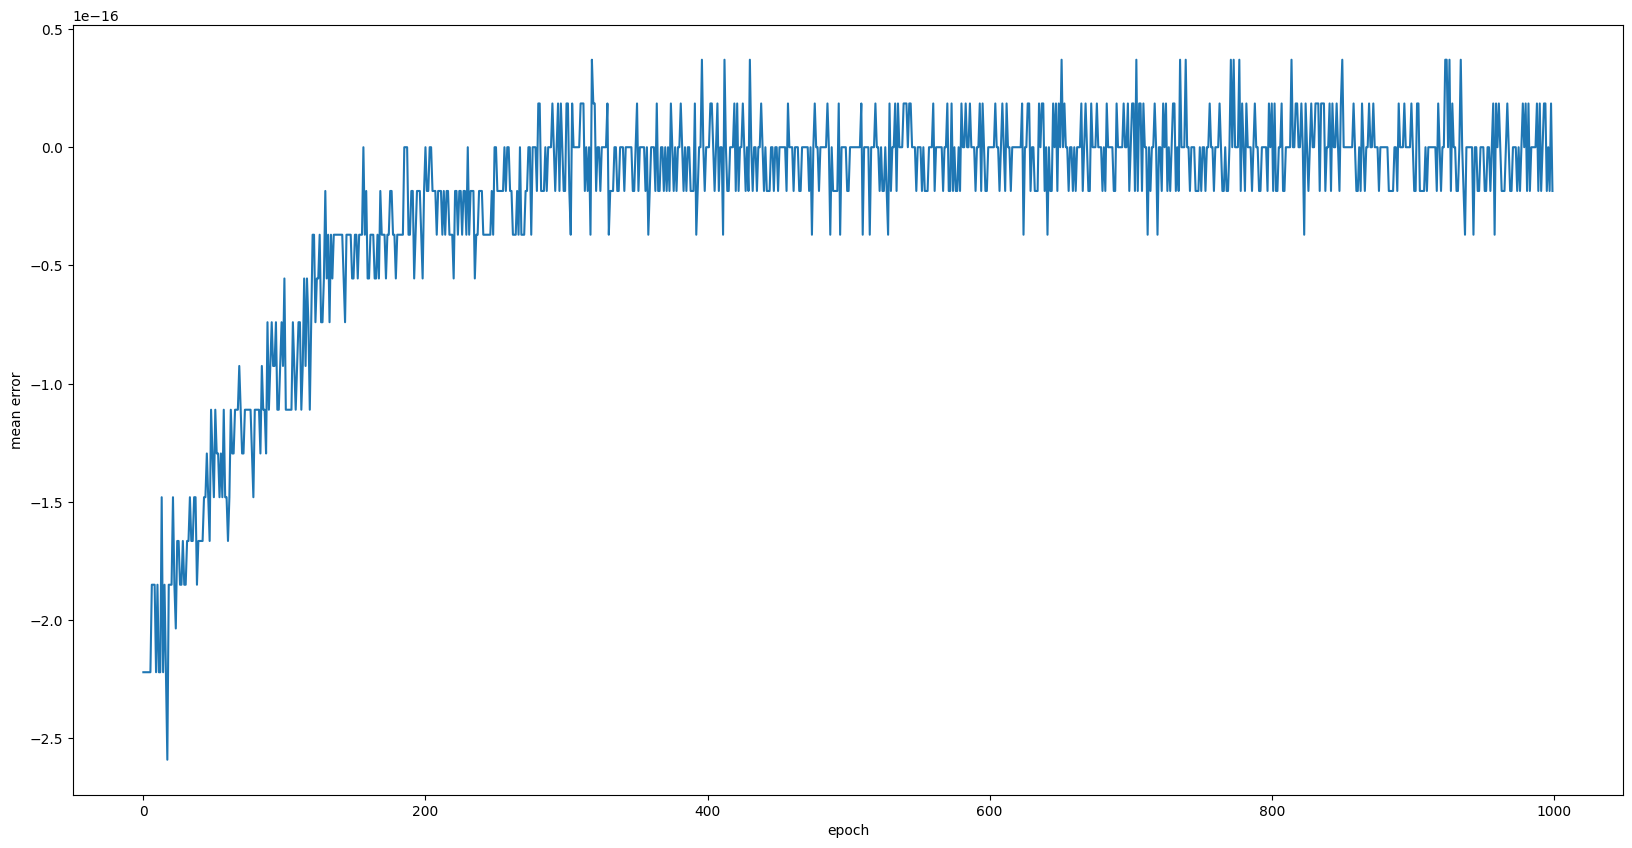

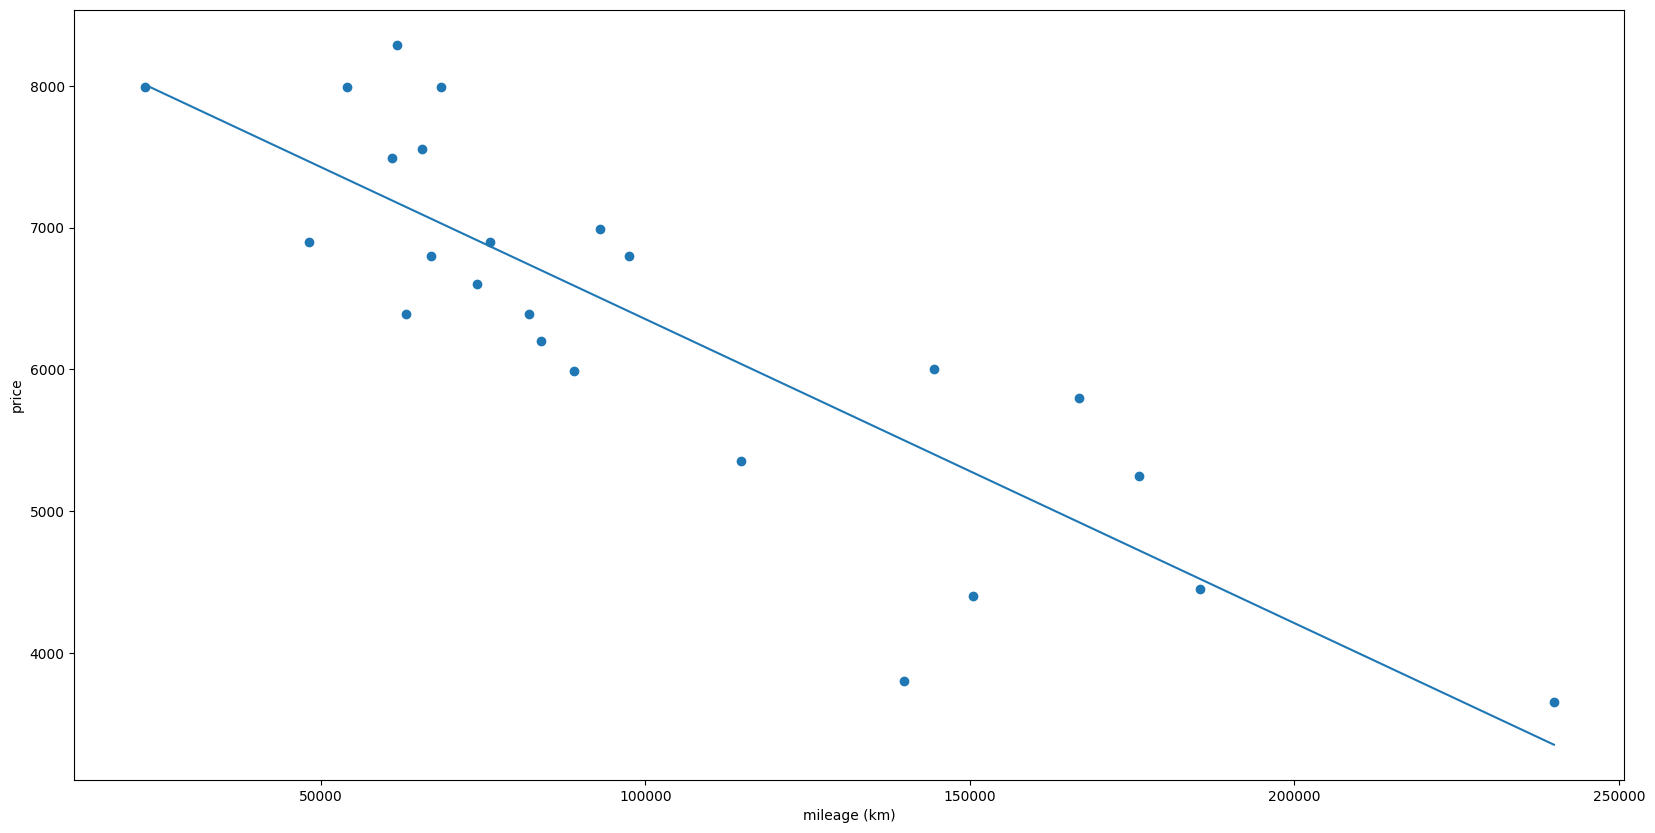

In [72]:
with open('data.csv') as data_file:
    data_reader = csv.reader(data_file)
    raw_data = list(data_reader)
    # Slice to remove the first row (column names), convert to float and store in a numpy array
    data = np.array([[float(row[0]), float(row[1])] for row in raw_data[1:]])
    y = data[:, 1]
    X = data[:, 0:1]

    model = LinearModel()
    parameters, mean_error_history = model.fit(X, y, learning_rate=0.01, iterations=1000)
    print(f'Model parameters: {parameters}')

    plt.rcParams["figure.figsize"] = (20, 10)
    plt.xlabel('epoch')
    plt.ylabel('mean error')
    plt.plot(np.arange(len(mean_error_history)), mean_error_history)
    plt.show()

    xs_model = np.reshape(np.linspace((min(data[:, 0])), max(data[:, 0]), 100), (100, 1))
    ys_model = model.predict(xs_model)
    plt.xlabel('mileage (km)')
    plt.ylabel('price')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(xs_model, ys_model)
    plt.show()